In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
import os

# 'problem' klasörünün içeriğini listeleyelim
os.listdir('/content/drive/MyDrive/hata/ALT REASON/ÜRÜN YANLIŞ')


['urunazAltR.ipynb', 'urunyanlis_altr.xlsx']

In [ ]:
import pandas as pd
from torch.optim import AdamW
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [ ]:
file_path='/content/drive/MyDrive/hata/ALT REASON/ÜRÜN YANLIŞ/urunyanlis_altr.xlsx'
df = pd.read_excel(file_path)


In [ ]:
df.head()
nan_rows = df[df["MAP"].isna()]
nan_rows = df[df["Yorum"].isna()]

print(nan_rows)

Empty DataFrame
Columns: [Müşteri Reasonı, Yorum, MAP]
Index: []


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811 entries, 0 to 2810
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Müşteri Reasonı  2811 non-null   object
 1   Yorum            2811 non-null   object
 2   MAP              2811 non-null   object
dtypes: object(3)
memory usage: 66.0+ KB


In [ ]:
df = df[['Yorum', 'MAP']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811 entries, 0 to 2810
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Yorum   2811 non-null   object
 1   MAP     2811 non-null   object
dtypes: object(2)
memory usage: 44.1+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811 entries, 0 to 2810
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Yorum   2811 non-null   object
 1   MAP     2811 non-null   object
dtypes: object(2)
memory usage: 44.1+ KB


In [ ]:
df.duplicated().sum()

np.int64(18)

In [ ]:
df[df.duplicated()]


,Yorum,MAP
133,2 alışverişimde yanlış gönderildi. 36 numara a...,Ürün yanlış numara/beden gönderildi
135,Numarası Yanlış gönderildi ben de iade ettim. ...,Ürün yanlış numara/beden gönderildi
137,Aldığım üründen farklı markada bir ürün geldi....,Farklı markaya ait farklı ürün gönderildi​
138,3 ürün gelmesi 2 ürün gönderildi. Daha sonra e...,Eksik ürün gönderildi
271,1+1 ayakkabı kampanyasından 2 çift sipariş ett...,Eksik ürün gönderildi
561,"Sneaker sipariş ettim, alakasız bir modelde kl...",Farklı kategoriden bir ürün gönderildi​
585,"Spor ayakkabı sipariş ettim, ama bir bere gönd...",Farklı kategoriden bir ürün gönderildi​
587,"Sneaker sipariş etmiştim, yerine bir kolye gel...",Farklı kategoriden bir ürün gönderildi​
590,"Kışlık ayakkabı sipariş ettim, yerine bir şapk...",Farklı kategoriden bir ürün gönderildi​
595,"Sneaker sipariş ettim, ama bir ceket gönderild...",Farklı kategoriden bir ürün gönderildi​


In [ ]:
df["MAP"].value_counts()

,count
MAP,
Farklı kategoriden bir ürün gönderildi​,259
Ürünüm defolu geldi,259
Ürünümün kalitesinden memnun kalmadım,258
Eksik ürün gönderildi,257
Farklı markaya ait farklı ürün gönderildi​,255
Müşteri temsilcisi yardımcı olmadı,255
Ürün yanlış numara/beden gönderildi,255
Farklı model ürün gönderildi,254
Ürün yanlış renk gönderildi​,253


In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['MAP'].values)


In [ ]:
label_encoder.classes_

array(['Eksik ürün gönderildi',
       'Farklı kategoriden bir ürün gönderildi\u200b',
       'Farklı markaya ait farklı ürün gönderildi\u200b',
       'Farklı model ürün gönderildi', 'Kalıbı küçüktü/büyüktü',
       'Müşteri temsilcisi yardımcı olmadı',
       'Ürün yanlış numara/beden gönderildi',
       'Ürün yanlış renk gönderildi\u200b', 'Ürünüm defolu geldi',
       'Ürünümün iki teki birbirinden farklıydı/aynıydı',
       'Ürünümün kalitesinden memnun kalmadım'], dtype=object)

In [ ]:
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if torch.cuda.is_available():
    print("GPU kullanılabilir.")
else:
    print("GPU kullanılabilir değil. CPU kullanılıyor.")

GPU kullanılabilir.


In [ ]:
import torch

# PyTorch sürümünü yazdır
print("PyTorch Sürümü:", torch.__version__)

# CUDA'nın kullanılabilirliğini kontrol et ve versiyonunu yazdır
if torch.cuda.is_available():
    print("CUDA Sürümü:", torch.version.cuda)
    print("CUDA kullanılabilir ve GPU kullanılıyor.")
else:
    print("CUDA kullanılabilir değil. CPU kullanılıyor.")

PyTorch Sürümü: 2.6.0+cu124
CUDA Sürümü: 12.4
CUDA kullanılabilir ve GPU kullanılıyor.


In [ ]:
labels

array([0, 0, 0, ..., 7, 7, 7])

In [ ]:
def tokenize_data(texts):
    texts = texts.tolist()
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=256)

X_train, X_test, y_train, y_test = train_test_split(df['Yorum'], labels, test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42,stratify=y_train)

len(X_train),len(X_test), len(X_val)


(2276, 282, 253)

In [ ]:
print("Eğitim seti dağılımı:")
print(pd.Series(y_train).value_counts())

print("\nTest seti dağılımı:")
print(pd.Series(y_test).value_counts())

print("\nDoğrulama seti dağılımı:")
print(pd.Series(y_val).value_counts())



Eğitim seti dağılımı:
1     210
8     210
10    209
0     208
2     206
6     206
3     206
5     206
9     205
7     205
4     205
Name: count, dtype: int64

Test seti dağılımı:
0     26
5     26
8     26
10    26
1     26
2     26
6     26
7     25
9     25
4     25
3     25
Name: count, dtype: int64

Doğrulama seti dağılımı:
7     23
8     23
10    23
9     23
0     23
3     23
6     23
5     23
4     23
1     23
2     23
Name: count, dtype: int64


In [ ]:
train_inputs = tokenize_data(X_train)
val_inputs = tokenize_data(X_val)
test_inputs = tokenize_data(X_test)

In [ ]:
def decode_tokens(input_ids):
    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)

decoded_train_texts = decode_tokens(train_inputs['input_ids'][:5])
decoded_val_texts = decode_tokens(val_inputs['input_ids'][:5])
decoded_test_texts = decode_tokens(test_inputs['input_ids'][:5])

# train_batch değişkenini bu noktada tanımlayın
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(y_train, dtype=torch.long))
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
train_batch = next(iter(train_dataloader)) # train_batch burada tanımlanıyor

decoded_train_texts = decode_tokens(train_batch[0][:2])  # İlk 2 örneği dönüştür
print("Decoded Train Batch Texts (İlk 2 örnek):\n", decoded_train_texts)

print("\nTokenize Edilmiş Train Metinleri (İlk 5 örnek):\n", decoded_train_texts)
print("\nTokenize Edilmiş Val Metinleri (İlk 5 örnek):\n", decoded_val_texts)
print("\nTokenize Edilmiş Test Metinleri (İlk 5 örnek):\n", decoded_test_texts)

# ... (Geri kalan kodunuz)

Decoded Train Batch Texts (İlk 2 örnek):
 ['Siyah sandalet sipariş ettim, biri siyah biri kahverengi, müşteri hizmetleri yardımcı oldu, iade ettim.', 'Kampanyalı alışverişimde 2 çift bot sipariş ettim, sadece 1 çift geldi. Diğerinin tedarik edilemeyeceği söylendi.']

Tokenize Edilmiş Train Metinleri (İlk 5 örnek):
 ['Siyah sandalet sipariş ettim, biri siyah biri kahverengi, müşteri hizmetleri yardımcı oldu, iade ettim.', 'Kampanyalı alışverişimde 2 çift bot sipariş ettim, sadece 1 çift geldi. Diğerinin tedarik edilemeyeceği söylendi.']

Tokenize Edilmiş Val Metinleri (İlk 5 örnek):
 ['Siyah rugan ayakkabı istedim, gelen mat siyah ve deri tipi de farklıydı.', 'Gelen spor ayakkabının yan tarafında ciddi bir ezik vardı, değiştirmeye bile değmezdi.', 'Botun fermuarı sürekli takılıyor ve zor kapanıyor. Kalitesiz bir fermuar kullanmışlar.', 'Siyah spor ayakkabı sipariş ettim, kutu açtığımda içinden turuncu renk çıktı. Görselle hiçbir alakası yoktu, hemen iade ettim.', 'Spor ayakkabının bağcı

In [ ]:

print("Train Inputs Anahtarları:", train_inputs.keys())
print("Train Input IDs Şekli:", train_inputs['input_ids'].shape)
print("Train Attention Mask Şekli:", train_inputs['attention_mask'].shape)
print()
print("\nVal Inputs Anahtarları:", val_inputs.keys())
print("Val Input IDs Şekli:", val_inputs['input_ids'].shape)
print("Val Attention Mask Şekli:", val_inputs['attention_mask'].shape)
print()
print("\nTest Inputs Anahtarları:", test_inputs.keys())
print("Test Input IDs Şekli:", test_inputs['input_ids'].shape)
print("Test Attention Mask Şekli:", test_inputs['attention_mask'].shape)

def decode_tokens(input_ids):
    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)

decoded_train_texts = decode_tokens(train_inputs['input_ids'][:5])
decoded_val_texts = decode_tokens(val_inputs['input_ids'][:5])
decoded_test_texts = decode_tokens(test_inputs['input_ids'][:5])

decoded_train_texts = decode_tokens(train_batch[0][:2])  # İlk 2 örneği dönüştür
print("Decoded Train Batch Texts (İlk 2 örnek):\n", decoded_train_texts)

print("\nTokenize Edilmiş Train Metinleri (İlk 5 örnek):\n", decoded_train_texts)
print("\nTokenize Edilmiş Val Metinleri (İlk 5 örnek):\n", decoded_val_texts)
print("\nTokenize Edilmiş Test Metinleri (İlk 5 örnek):\n", decoded_test_texts)

train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(y_test, dtype=torch.long))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train DataLoader Uzunluğu (Batch Sayısı):", len(train_dataloader))
print("Val DataLoader Uzunluğu (Batch Sayısı):", len(val_dataloader))
print("Test DataLoader Uzunluğu (Batch Sayısı):", len(test_dataloader))


train_batch = next(iter(train_dataloader))
print("Train Batch Input IDs Şekli:", train_batch[0].shape)
print("Train Batch Attention Mask Şekli:", train_batch[1].shape)
print("Train Batch Etiket Şekli:", train_batch[2].shape)

val_batch = next(iter(val_dataloader))
print("\nVal Batch Input IDs Şekli:", val_batch[0].shape)
print("Val Batch Attention Mask Şekli:", val_batch[1].shape)
print("Val Batch Etiket Şekli:", val_batch[2].shape)

test_batch = next(iter(test_dataloader))
print("\nTest Batch Input IDs Şekli:", test_batch[0].shape)
print("Test Batch Attention Mask Şekli:", test_batch[1].shape)
print("Test Batch Etiket Şekli:", test_batch[2].shape)

print("Train Batch Input IDs (İlk 2 örnek):\n", train_batch[0][:2])
print("\nTrain Batch Attention Mask (İlk 2 örnek):\n", train_batch[1][:2])
print("\nTrain Batch Etiketleri (İlk 2 örnek):\n", train_batch[2][:2])


def decode_tokens(input_ids):
    return tokenizer.batch_decode(input_ids, skip_special_tokens=True)



print("Train DataLoader Batch Size:", train_dataloader.batch_size)
print("Train DataLoader Shuffle:", train_dataloader.sampler.shuffle if hasattr(train_dataloader.sampler, 'shuffle') else "Shuffle bilgisi yok")





Train Inputs Anahtarları: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Train Input IDs Şekli: torch.Size([2276, 81])
Train Attention Mask Şekli: torch.Size([2276, 81])


Val Inputs Anahtarları: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Val Input IDs Şekli: torch.Size([253, 55])
Val Attention Mask Şekli: torch.Size([253, 55])


Test Inputs Anahtarları: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Test Input IDs Şekli: torch.Size([282, 48])
Test Attention Mask Şekli: torch.Size([282, 48])
Decoded Train Batch Texts (İlk 2 örnek):
 ['Siyah sandalet sipariş ettim, biri siyah biri kahverengi, müşteri hizmetleri yardımcı oldu, iade ettim.', 'Kampanyalı alışverişimde 2 çift bot sipariş ettim, sadece 1 çift geldi. Diğerinin tedarik edilemeyeceği söylendi.']

Tokenize Edilmiş Train Metinleri (İlk 5 örnek):
 ['Siyah sandalet sipariş ettim, biri siyah biri kahverengi, müşteri hizmetleri yardımcı oldu, iade ettim.', 'Kampanyalı alışverişimde 2 çift

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
for map in df.MAP.unique():
  mapCount = len(df[df["MAP"]==map])
  print(f"Map : {map} , Sayısı : {mapCount}")
print()


Map : Eksik ürün gönderildi , Sayısı : 257
Map : Farklı kategoriden bir ürün gönderildi​ , Sayısı : 259
Map : Farklı markaya ait farklı ürün gönderildi​ , Sayısı : 255
Map : Farklı model ürün gönderildi , Sayısı : 254
Map : Ürün yanlış numara/beden gönderildi , Sayısı : 255
Map : Ürün yanlış renk gönderildi​ , Sayısı : 253
Map : Ürünüm defolu geldi , Sayısı : 259
Map : Ürünümün iki teki birbirinden farklıydı/aynıydı , Sayısı : 253
Map : Kalıbı küçüktü/büyüktü , Sayısı : 253
Map : Ürünümün kalitesinden memnun kalmadım , Sayısı : 258
Map : Müşteri temsilcisi yardımcı olmadı , Sayısı : 255



In [ ]:
# Optimizer ve scheduler'ı ayarlayın
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)
epochs = 15
total_steps = len(train_dataloader) * epochs # Train dataloader'dan gelen batch sayısını kullanarak toplam adım sayısını hesaplayın
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Model eğitiliyor...
Epoch 1, Loss: 1.2008, Val Loss: 0.3084
Epoch 2, Loss: 0.2284, Val Loss: 0.3090
Epoch 3, Loss: 0.0943, Val Loss: 0.2014
Epoch 4, Loss: 0.0570, Val Loss: 0.1752
Epoch 5, Loss: 0.0378, Val Loss: 0.1711
Epoch 6, Loss: 0.0221, Val Loss: 0.2470
Epoch 7, Loss: 0.0158, Val Loss: 0.2054
Epoch 8, Loss: 0.0084, Val Loss: 0.2481
Early stopping tetiklendi! En İyi Epoch Sayısı: 5, En iyi val loss: 0.1711
Model test ediliyor...
Test Accuracy: 0.9397


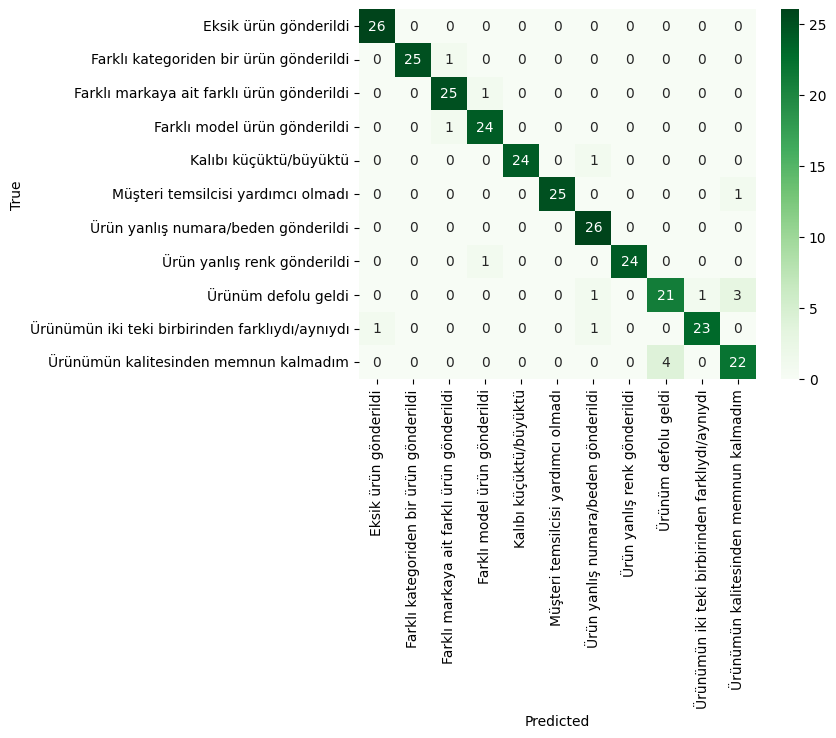

Model başarıyla kaydedildi!


In [ ]:
# TensorBoard yazıcıyı başlatın
writer = SummaryWriter(log_dir='./logs')

## Model Eğitim Fonksiyonu
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10, patience=5):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):

        total_loss = 0
        model.train()
        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_loss = total_loss / len(train_dataloader)

        # **Validation loss hesaplama**
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                val_loss += outputs.loss.item()
        avg_val_loss = val_loss / len(val_dataloader)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        writer.add_scalars('Loss', {'train': avg_loss, 'val': avg_val_loss}, epoch)

        # **Early Stopping kontrolü**
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1  # En iyi epoch'u güncelle
            patience_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/hata/ALT REASON/ÜRÜN YANLIŞ/best_model.pth')  # En iyi modeli kaydet
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping tetiklendi! En İyi Epoch Sayısı: {best_epoch}, En iyi val loss: {best_val_loss:.4f}") # best_epoch'u yazdır
            break

## Model Değerlendirme Fonksiyonu
def evaluate_model(model, test_dataloader):
    model.load_state_dict(torch.load('/content/drive/MyDrive/hata/ALT REASON/ÜRÜN YANLIŞ/best_model.pth'))  # En iyi modeli yükle
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=-1).cpu().numpy())
            true_labels.extend(b_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return accuracy

# # # Eğitim Başlatma
print("Model eğitiliyor...")
train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10, patience=3)

# Modeli Test Etme
print("Model test ediliyor...")
evaluate_model(model, test_dataloader)

# Model ve tokenizer'ı kaydetme
model.save_pretrained("/content/drive/MyDrive/hata/ALT REASON/ÜRÜN YANLIŞ/bert_finetuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/hata/ALT REASON/ÜRÜN YANLIŞ/bert_finetuned_model")
print("Model başarıyla kaydedildi!")

Test Accuracy: 0.9930


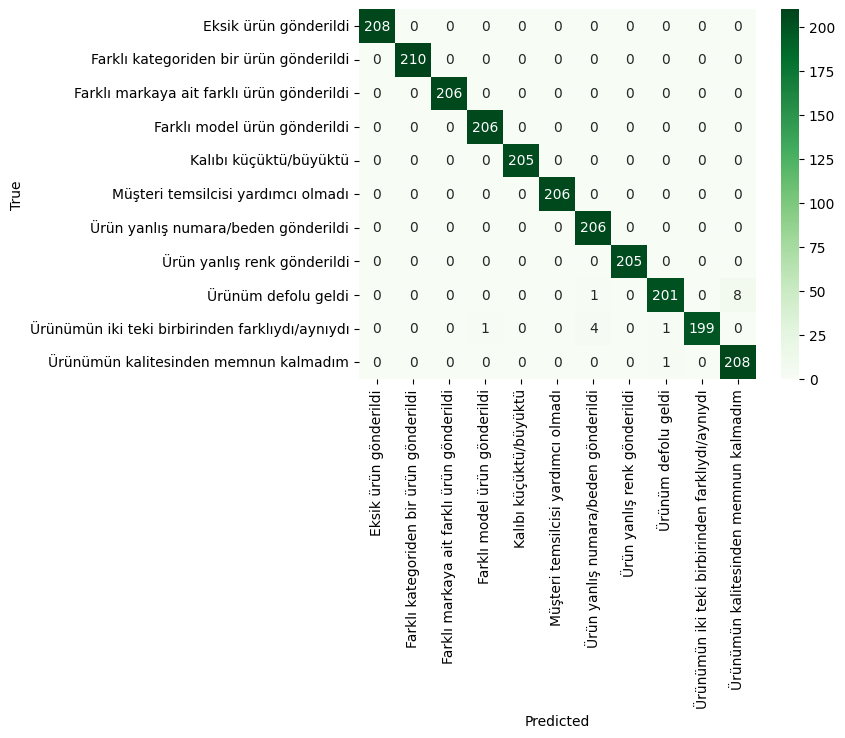

0.9929701230228472

In [ ]:

evaluate_model(model, train_dataloader)


In [ ]:
import numpy as np
import torch

# Varsayımlar:
# - X_test, test verilerini içeren bir Pandas DataFrame veya Series
# - y_test, gerçek etiketleri içeren bir NumPy dizisi
# - label_encoder, etiketleri kodlamak için kullanılan bir sklearn LabelEncoder nesnesi
# - tokenize_data, metinleri token'lara dönüştüren bir fonksiyon
# - model, tahmin yapmak için kullanılan bir PyTorch modeli
# - device, modelin üzerinde çalıştığı cihaz (CPU veya GPU)

def hatalari_yazdir(X_test, y_test, label_encoder, tokenize_data, model, device):
    hatali_ornekler = []

    for ix in range(len(X_test)):
        text = X_test.iloc[ix]
        true_label = label_encoder.classes_[y_test[ix]]

        token = tokenize_data(np.array([text]))
        b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
        predicted_label = label_encoder.classes_[pred]

        if true_label != predicted_label:
            hatali_ornekler.append({
                "metin": text,
                "gercek_deger": true_label,
                "tahmin_edilen_deger": predicted_label
            })

    if not hatali_ornekler:
        print("Tahminlerde hata bulunmamaktadır.")
    else:
        for ornek in hatali_ornekler:
            print("--------------------------------------------------")
            print(f"Metin: {ornek['metin']}")
            print(f"Gerçek Değer: {ornek['gercek_deger']}")
            print(f"Tahmin Edilen Değer: {ornek['tahmin_edilen_deger']}")

# Kullanım örneği:
hatalari_yazdir(X_test, y_test, label_encoder, tokenize_data, model, device)

--------------------------------------------------
Metin: Terliğin bir ayağı dar, diğeri bol geldi. Kalıp hatası var gibi.
Gerçek Değer: Ürünüm defolu geldi
Tahmin Edilen Değer: Ürünümün iki teki birbirinden farklıydı/aynıydı
--------------------------------------------------
Metin: Krem rengi çizme geldi, sağ tekin kalıbı büyük, sol teki normal, iade ettim.
Gerçek Değer: Ürünüm defolu geldi
Tahmin Edilen Değer: Ürün yanlış numara/beden gönderildi
--------------------------------------------------
Metin: 1a1b kampanyasından ürün aldım. 1600 tl ye aldığım ayakakbıyı ertesi gün 1400 tl ye düştü. Ayakkabı da yanlış renk geldi.
Gerçek Değer: Ürün yanlış renk gönderildi​
Tahmin Edilen Değer: Farklı model ürün gönderildi
--------------------------------------------------
Metin: Kahverengi ayakkabı aldım, dikişler bozuk, birkaç giymede açıldı, iade süreci başlattım.
Gerçek Değer: Ürünümün kalitesinden memnun kalmadım
Tahmin Edilen Değer: Ürünüm defolu geldi
-----------------------------------

In [ ]:
import pandas as pd
from google.colab import files

def hatalari_yazdir_ve_kaydet(X_test, y_test, label_encoder, tokenize_data, model, device, dosya_adi="hatalar.xlsx"):
    hatali_ornekler = []

    for ix in range(len(X_test)):
        text = X_test.iloc[ix]
        true_label = label_encoder.classes_[y_test[ix]]

        token = tokenize_data(np.array([text]))
        b_input_ids, b_attention_mask = token["input_ids"].to(device), token["attention_mask"].to(device)
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, axis=-1).cpu().numpy()[0]
        predicted_label = label_encoder.classes_[pred]

        if true_label != predicted_label:
            hatali_ornekler.append({
                "Yorum": text,
                "Gerçek değer": true_label,
                "Tahmin değeri": predicted_label
            })

    if not hatali_ornekler:
        print("Tahminlerde hata bulunmamaktadır.")
    else:
        # Hatalı verileri DataFrame'e çevir
        hatali_df = pd.DataFrame(hatali_ornekler)

        # DataFrame'i Excel dosyasına kaydet
        hatali_df.to_excel(dosya_adi, index=False)
        print(f"Hatalı veriler {dosya_adi} olarak kaydedildi.")

        # Dosyayı Colab üzerinden indirme
        files.download(dosya_adi)

# Kullanım örneği:
hatalari_yazdir_ve_kaydet(X_test, y_test, label_encoder, tokenize_data, model, device, "hatalar.xlsx")


Hatalı veriler hatalar.xlsx olarak kaydedildi.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>